# Dive Prediction - Hidden Markov Model

*Predicting Seabird Diving Behaviour from GPS data*

This notebook trains a HMM to predict seabirds' dives.

HMM' characteristics:

* *Number of modes* : 3

<div class="alert alert-info">
 ⚠️ Notebook using R
</div>

In [13]:
library(momentuHMM)

In [14]:
data_test = read.table("./data/data_test.csv", sep = ',', header = TRUE)

In [15]:
# prep data for HMM
rawData <- data_test[,c("trip","lon","lat")]
colnames(rawData) <- c("ID", "lon", "lat")
birdData <- prepData(data=rawData, type = "LL", coordNames = c("lon", "lat"))

In [16]:
# parameters initialization

## cluster K-Means for initialization
### STEP
clusterBird_step <- kmeans(na.omit(data.frame(birdData$step)), 3)
muS_1 <- max(clusterBird_step$centers)
muS_2 <- median(clusterBird_step$centers) 
muS_3 <- min(clusterBird_step$centers) 
sdS_1 <- sd(na.omit(birdData$step)[clusterBird_step[[1]] == which(clusterBird_step$centers == max(clusterBird_step$centers))])
sdS_2 <- sd(na.omit(birdData$step)[clusterBird_step[[1]] == which(clusterBird_step$centers == median(clusterBird_step$centers))])
sdS_3 <- sd(na.omit(birdData$step)[clusterBird_step[[1]] == which(clusterBird_step$centers == min(clusterBird_step$centers))])

### ANGLE
## for von mises
kappaA_1 <- 4
kappaA_2 <- 2
kappaA_3 <- 0.1

### ZERO MASS
zeroMass <- length(which(birdData$step == 0))/nrow(birdData) #we need to include zeroMass parameters

### FIT MODEL
stateNames <- c("fly","observe", "dive")
dist = list(step = "gamma", angle = "vm")
anglePar0 <- c(kappaA_1, kappaA_2, kappaA_3) 
stepPar0 <- c(muS_1, muS_2, muS_3, sdS_1, sdS_2, sdS_3, zeroMass, zeroMass, zeroMass) 

In [14]:
m <- fitHMM(data = birdData, nbStates = 3, dist = dist,
            Par0 = list(step = stepPar0, angle = anglePar0), stateNames = stateNames, formula = ~1)

save(m, file = './hmm/hmm_test.RData')


Fitting HMM with 3 states and 2 data streams

-----------------------------------------------------------------------


 step ~ gamma(mean=~1, sd=~1, zeromass=~1)

 angle ~ vm(concentration=~1)


 Transition probability matrix formula: ~1


 Initial distribution formula: ~1


DONE



In [17]:
load('./hmm/hmm_test.RData')

In [18]:
for (trip in unique(rawData$ID)){
  path = paste0('./hmm/figures/', trip, '.png')
  png(path)
  plot(m, animals = trip, ask = FALSE)
  dev.off()
}


Decoding state sequence... DONE
Decoding state sequence... DONE
Decoding state sequence... DONE
Decoding state sequence... DONE
Decoding state sequence... DONE
Decoding state sequence... DONE
Decoding state sequence... DONE


Decoding state sequence... DONE


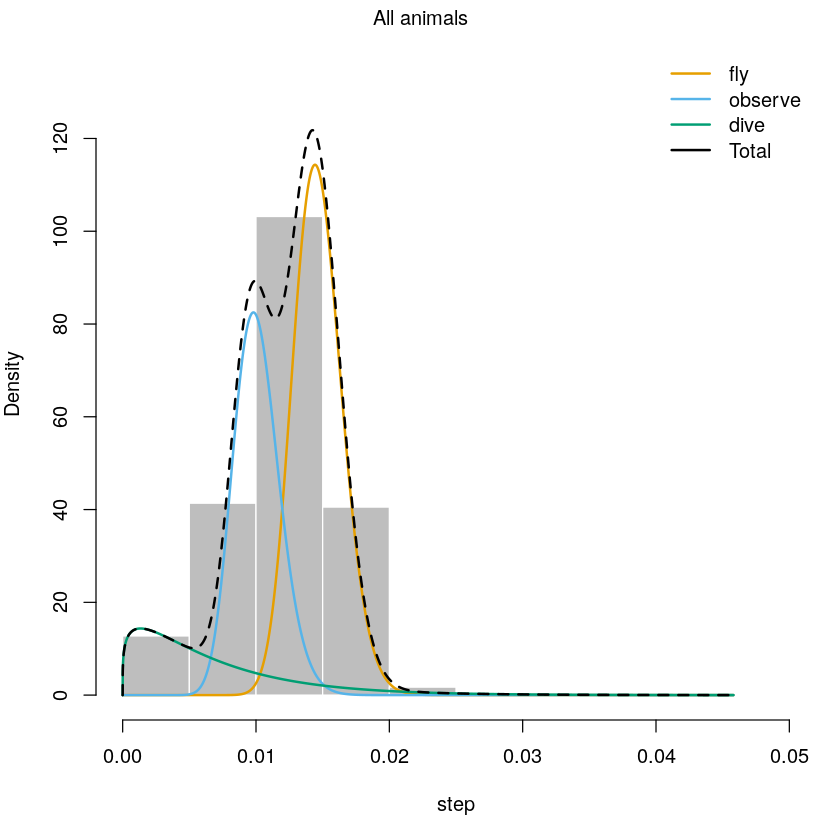

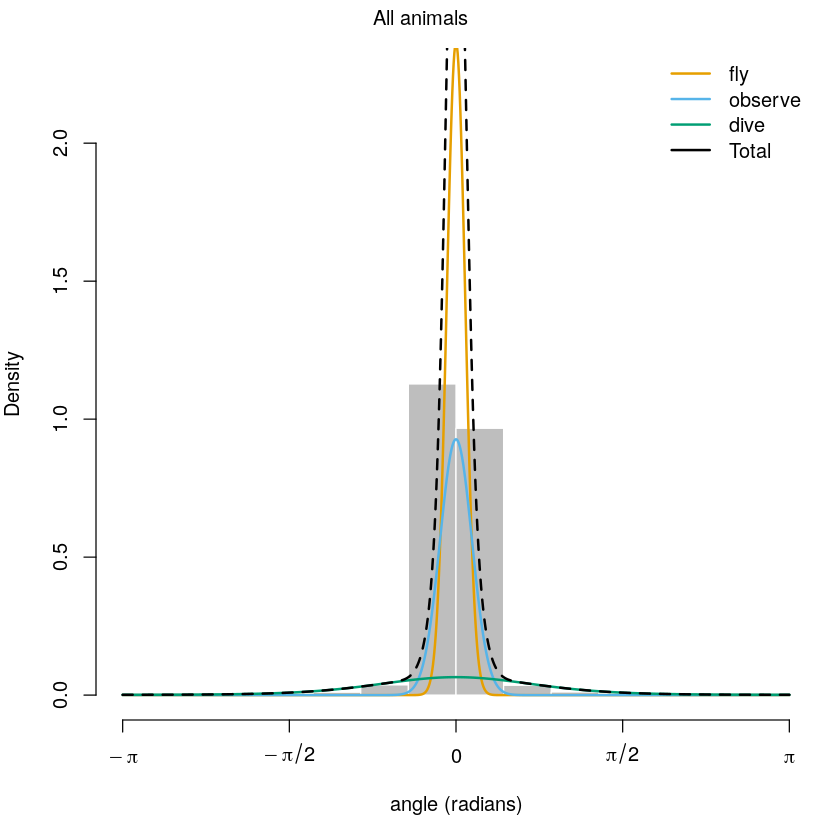

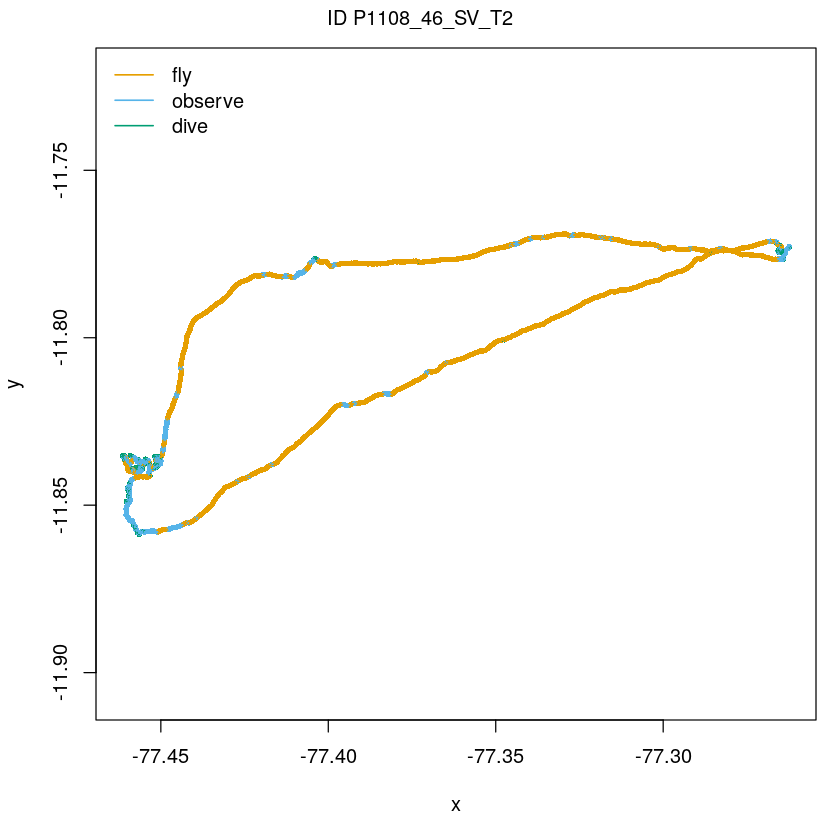

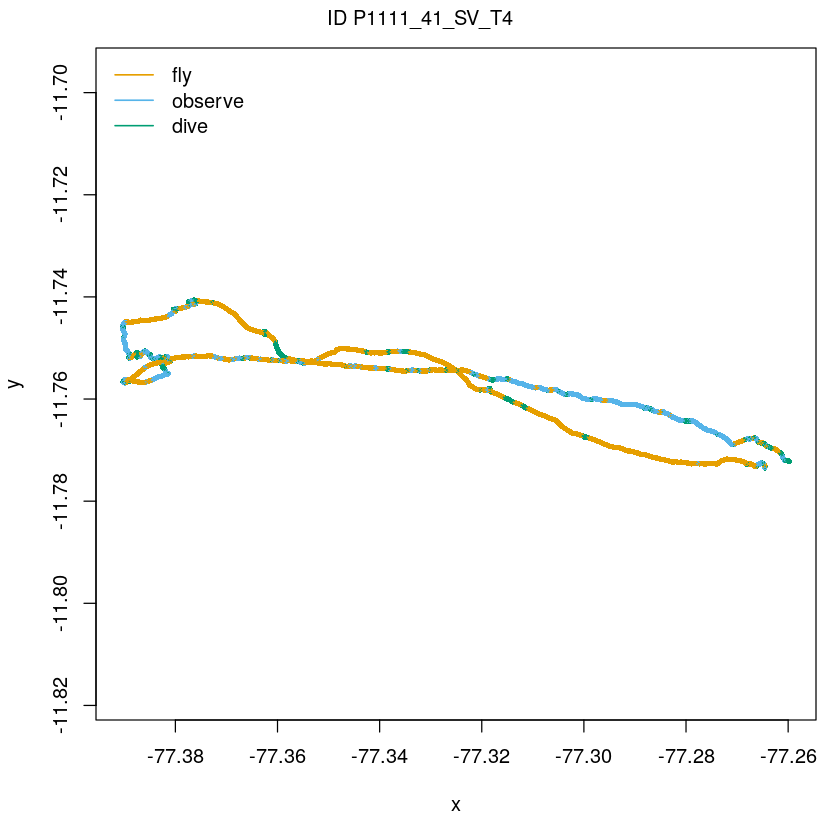

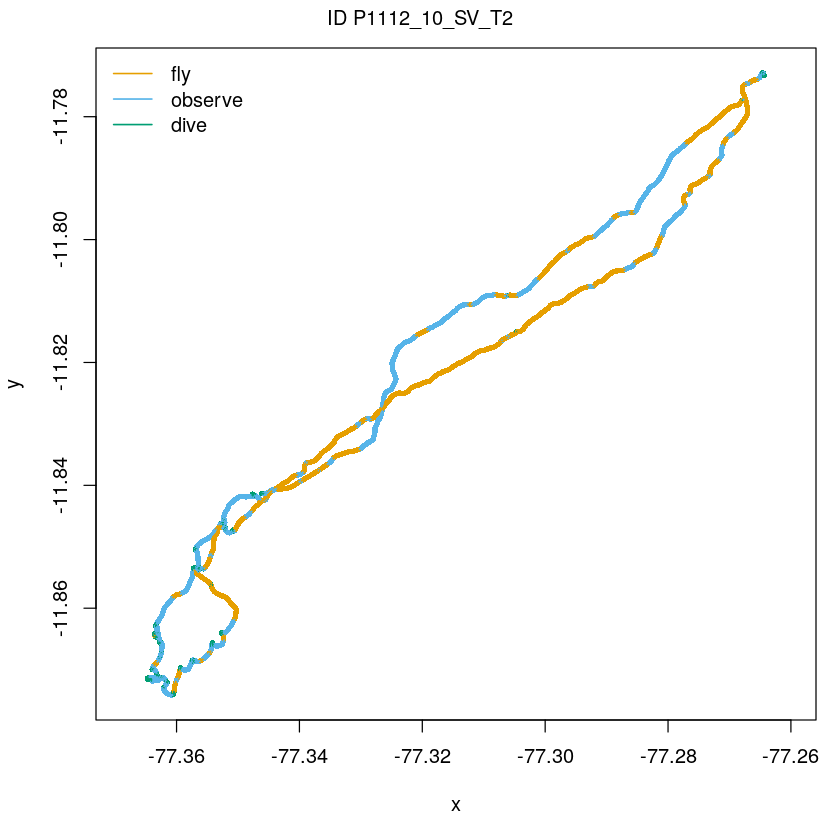

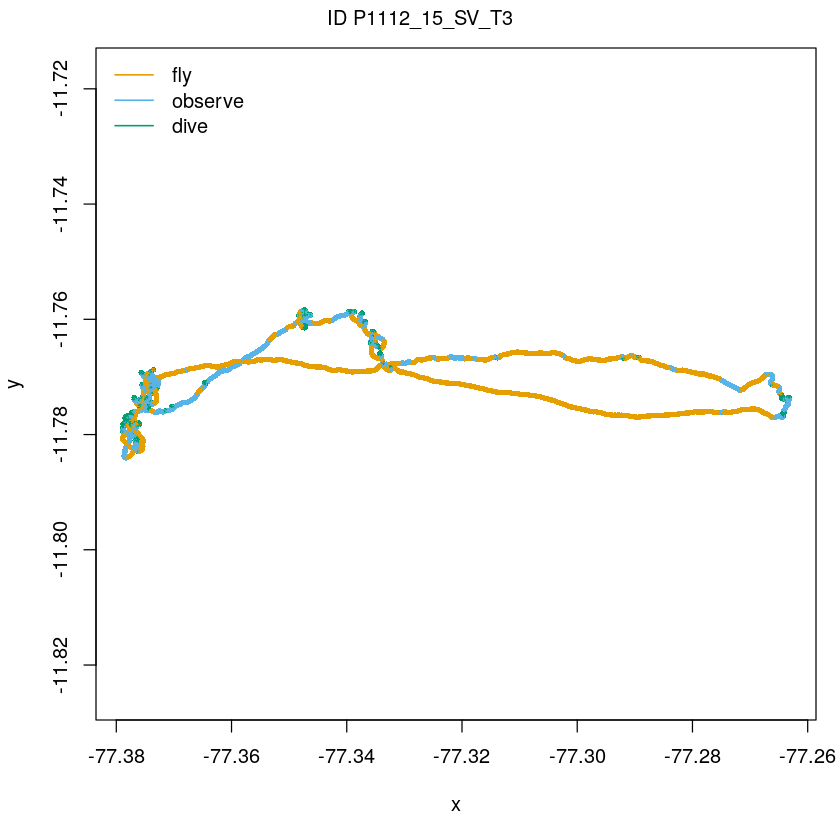

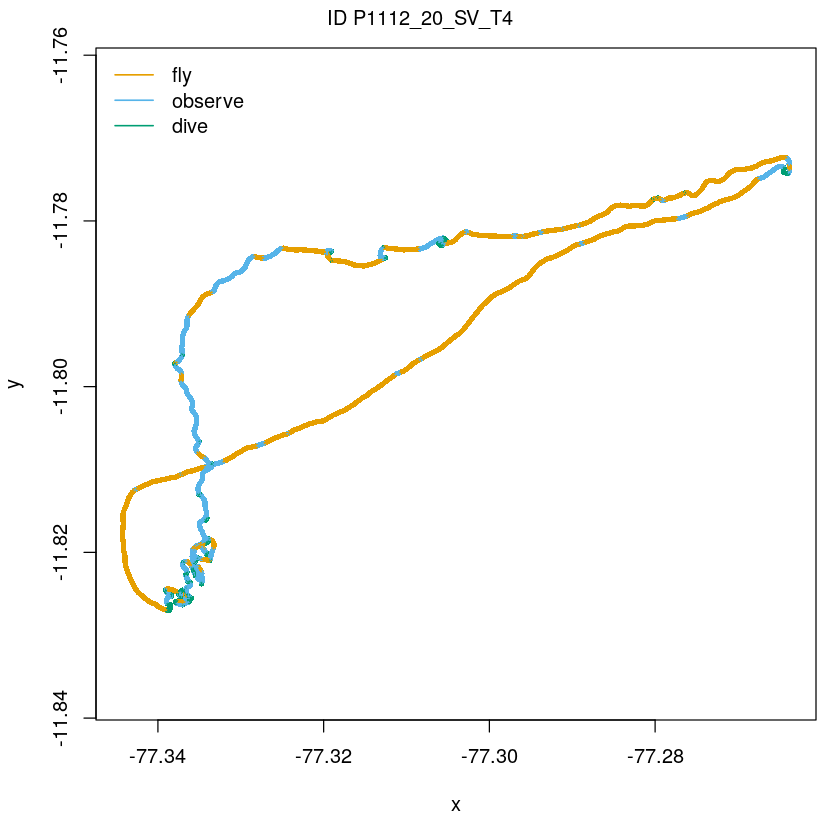

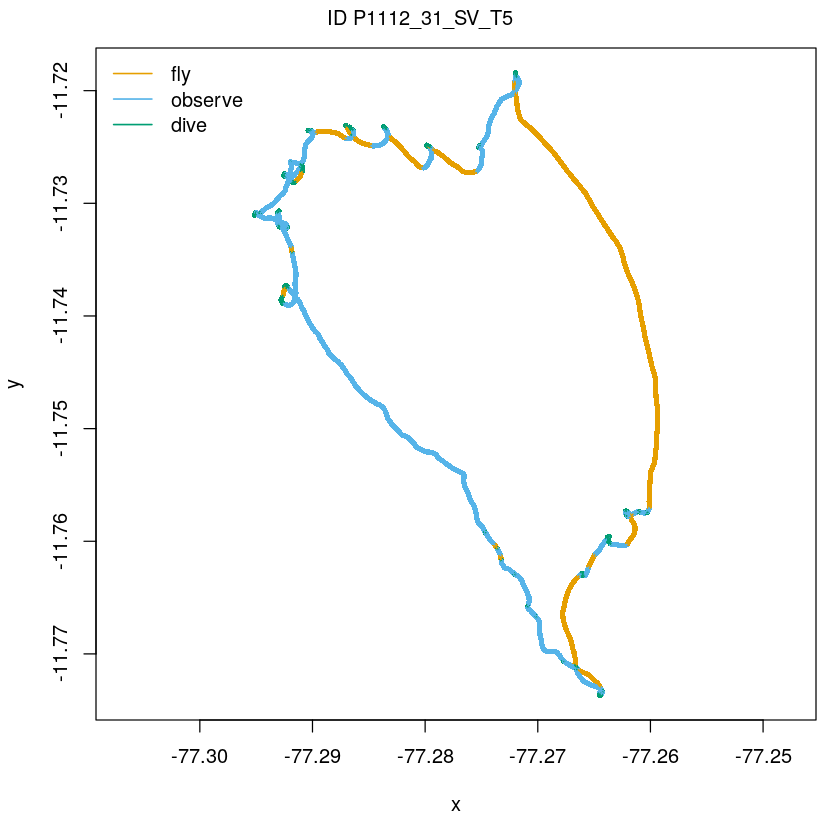

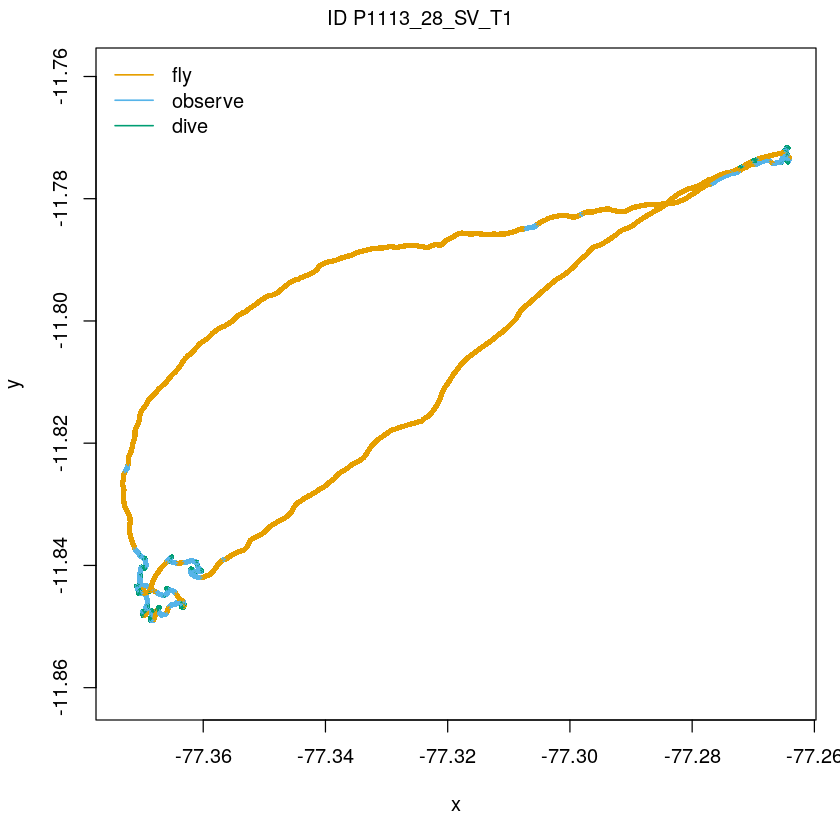

In [67]:
plot(m)

In [36]:
prob = stateProbs(m)
data_test$hmm = prob[, 'dive']

## change resolution

In [37]:
dive_real = list()
dive_estim = list()

for (i in unique(data_test$trip)){
    trip = data_test[data_test$trip == i,]
    
    real = sapply(seq(1,nrow(trip)-10, by = 10), function(i){
        max(trip$dive[i:(i+9)])
    })
    
    estim = sapply(seq(1,nrow(trip)-10, by = 10), function(i){
        max(trip$hmm[i:(i+9)])
    })
        
    dive_real[[i]] = real
    dive_estim[[i]] = estim
}

## score

In [40]:
# globally
all_estim <- unlist(dive_estim)
all_real <- unlist(dive_real)


true_positive = mean(all_estim[all_real == 1])
true_negative = 1-mean(all_estim[all_real == 0])

print(c(true_positive, true_negative))

[1] 0.8803726 0.7578349


# ROC curve

In [41]:
# globally
TP = list()
FP = list()

i = 1
for (tt in seq(0,1, by = 0.05)){
    # globally
    all_estim <- 1*unlist(dive_estim)>tt
    all_real <- unlist(dive_real)

    true_positive = mean(all_estim[all_real == 1])
    true_negative = 1-mean(all_estim[all_real == 0])
    
    TP[[i]] <- true_positive
    FP[[i]] <- 1- true_negative
    i = i+1
}

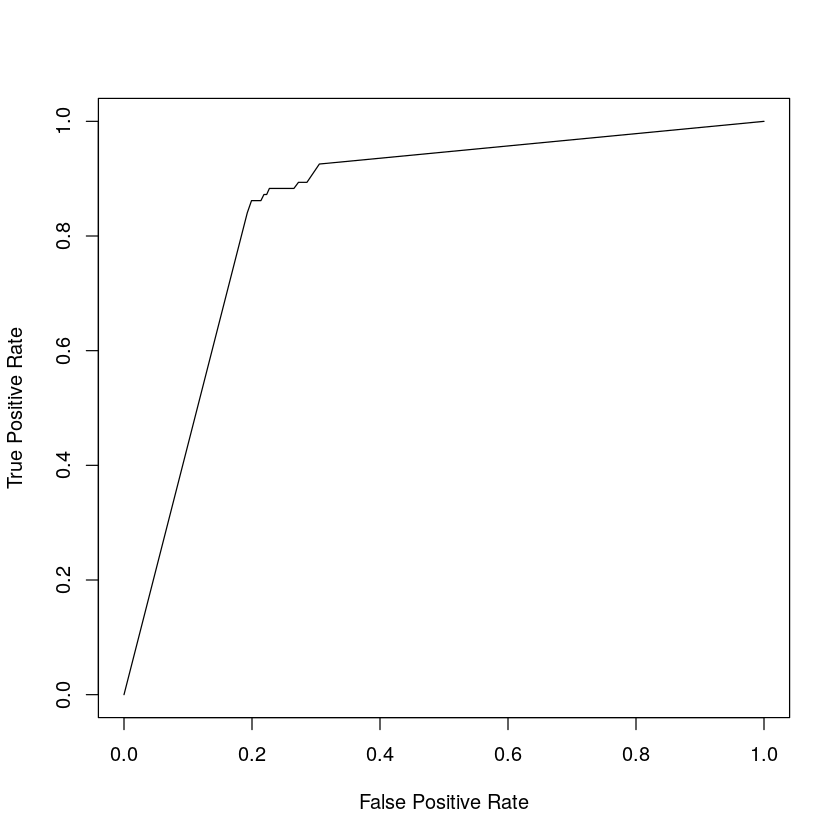

In [42]:
plot(unlist(FP), unlist(TP), pch = 19, xlab = 'False Positive Rate', ylab = 'True Positive Rate', type = 'l')

In [43]:
df = data.frame(model = 'hmm', FP = unlist(FP), TP = unlist(TP))

In [45]:
write.table(df, file = './roc_hmm.csv', sep = ',')

# Export Probabilities

In [57]:
all_estim <- unlist(dive_estim)
all_real <- unlist(dive_real)

In [58]:
df = data.frame(model = 'hmm', trip = substr(names(all_real), 1, 14), real = all_real, p = all_estim)
df

,model,trip,real,p
,<fct>,<fct>,<int>,<dbl>
P1108_46_SV_T21,hmm,P1108_46_SV_T2,0,9.829184e-01
P1108_46_SV_T22,hmm,P1108_46_SV_T2,0,1.017561e-02
P1108_46_SV_T23,hmm,P1108_46_SV_T2,0,8.638969e-04
P1108_46_SV_T24,hmm,P1108_46_SV_T2,0,3.400260e-04
P1108_46_SV_T25,hmm,P1108_46_SV_T2,0,1.000000e+00
P1108_46_SV_T26,hmm,P1108_46_SV_T2,0,8.662254e-01
P1108_46_SV_T27,hmm,P1108_46_SV_T2,0,3.097683e-02
P1108_46_SV_T28,hmm,P1108_46_SV_T2,0,2.399082e-02
P1108_46_SV_T29,hmm,P1108_46_SV_T2,0,4.564157e-06


In [60]:
write.table(df, file = './prob_hmm.csv', sep = ',', row.names=FALSE)